In [1]:
# 1. Встановлення бібліотек
!pip install torch torchvision transformers albumentations optuna
!pip install scikit-learn
!pip install -U albumentations


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.7/680.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.17
    Uninstalling albucore-0.0.17:
      Successfully uninstalled albucore-0.0.17
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.17
    Uninstalling albumentations-1.4.17:
      Successfully uninstalled albumentations-1.4.17


In [2]:
# 2. Імпорт необхідних бібліотек
import os
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from transformers import BertModel, BertTokenizer
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import optuna
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import numpy as np
from torch.cuda.amp import autocast, GradScaler
import re
from bs4 import BeautifulSoup


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 3. Функція для формування імені файлу зображення
def get_image_filename(pet_id, img_num):
    return f"{pet_id}-{img_num}.jpg"


In [4]:
# 4. Оцінка пам'яті CUDA
def estimate_cuda_memory(model, batch_size, input_ids_size, attention_mask_size, image_size):
    # Оцінка пам'яті на вхідних даних
    input_mem = batch_size * (input_ids_size + attention_mask_size + image_size) * 4 / (1024 ** 2)  # Мб

    # Оцінка пам'яті для параметрів моделі
    model_mem = sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # Мб

    # Оцінка додаткової пам'яті для тимчасових тензорів і буферів (зазвичай 50-70% від пам'яті моделі)
    buffer_mem = model_mem * 0.7  # Підходить як орієнтовна оцінка

    # Загальна оцінка пам'яті
    total_mem = input_mem + model_mem + buffer_mem
    print(f"Орієнтовне використання пам'яті CUDA: {total_mem:.2f} Мб (включаючи додаткові буфери)")

In [5]:
################################
"""Оптимізація ресурсів GPU"""#
################################

# 1. Функція збереження стану перед Optuna на CPU

def save_state_before_optuna(dataset, tokenizer, img_dir, train_idx, val_idx, file_path='state_before_optuna.pkl'):
    """
    Зберігає стан перед підбором параметрів Optuna на CPU.
    """
    state = {
        'dataset': dataset,
        'tokenizer': tokenizer,
        'img_dir': img_dir,
        'train_idx': train_idx,
        'val_idx': val_idx
    }
    with open(file_path, 'wb') as f:
        pickle.dump(state, f)
    print(f"Стан збережено в {file_path}. Продовжуємо підбір гіперпараметрів на GPU.")

    # Зупинка роботи
    #input("Робота призупинена. Натисніть Enter для продовження підбору на GPU...")



# 2. Функція завантаження стану перед підбором Optuna на GPU

def load_state_before_optuna(file_path='state_before_optuna.pkl'):
    """
    Завантажує стан перед початком підбору параметрів Optuna на GPU.
    """
    with open(file_path, 'rb') as f:
        state = pickle.load(f)

    dataset = state['dataset']
    tokenizer = state['tokenizer']
    img_dir = state['img_dir']
    train_idx = state['train_idx']
    val_idx = state['val_idx']

    print(f"Стан завантажено з {file_path}. Можна почати підбір параметрів на GPU.")
    return dataset, tokenizer, img_dir, train_idx, val_idx



In [6]:
# 5. Нормалізація тексту

# Словник скорочень для розширення
contractions = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will", "he's": "he is", "i'd": "i would", "i'll": "i will", "i'm": "i am",
    "i've": "i have", "isn't": "is not", "it's": "it is", "let's": "let us", "mustn't": "must not", "shan't": "shall not",
    "she'd": "she would", "she'll": "she will", "she's": "she is", "shouldn't": "should not", "that'd": "that would",
    "that's": "that is", "there's": "there is", "they'd": "they would", "they'll": "they will", "they're": "they are",
    "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have", "weren't": "were not",
    "what's": "what is", "who's": "who is", "won't": "will not", "wouldn't": "would not", "you're": "you are"
}

# Функція для розширення скорочень
def expand_contractions(text):
    for contraction, full_form in contractions.items():
        text = text.replace(contraction, full_form)
    return text

# Функція для видалення HTML-тегів
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

# Функція для видалення спеціальних символів і рідковживаних символів
def remove_rare_symbols(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Залишаємо тільки літери, цифри та пробіли
    return text

# Функція для видалення повторюваних символів
def remove_repeated_chars(text):
    return re.sub(r'(.)\1+', r'\1\1', text)  # Заміна більше ніж двох повторень одного символа на два

# Функція для нормалізації тексту
def normalize_text(text):
    text = expand_contractions(text)  # Розширення скорочень
    text = remove_html_tags(text)      # Видалення HTML-тегів
    text = remove_rare_symbols(text)   # Видалення спеціальних символів
    text = remove_repeated_chars(text) # Видалення повторюваних символів
    text = ' '.join(text.split())      # Видалення зайвих пробілів
    return text.strip()

In [7]:
# 6. Dataset клас для тренувальних даних
class PetDataset(Dataset):
    def __init__(self, df, tokenizer, img_dir, transform=None, max_length=192, is_test=False):
        self.df = df
        self.tokenizer = tokenizer
        self.img_dir = img_dir
        self.transform = transform
        self.max_length = max_length
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Токенізація тексту
        text = row['Description']
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        pet_id = row['PetID']
        images = []

        # Шукаємо всі зображення для поточного PetID
        for img_num in range(1, 31):  # Вважаємо, що максимум 30 зображень для одного PetID
            img_path = os.path.join(self.img_dir, get_image_filename(pet_id, img_num))
            if os.path.exists(img_path):
                image = cv2.imread(img_path)
                if self.transform and image is not None:
                    image = self.transform(image=image)['image']  # Аугментація
                    images.append(image)
            else:
                break  # Зупиняємо пошук, якщо зображення з таким номером більше не існує

        # Якщо немає жодного зображення, використовуємо нульовий тензор
        if len(images) == 0:
            images = [torch.zeros((3, 340, 240))]  # Додаємо нульовий тензор як "заглушку"

        # Агрегація зображень (наприклад, середнє значення всіх зображень)
        if len(images) > 1:
            images = torch.stack(images)  # Перетворюємо список зображень в тензор
            image = torch.mean(images, dim=0)  # Беремо середнє значення
        else:
            image = images[0]  # Якщо тільки одне зображення, використовуємо його

        # Повертаємо результати
        if not self.is_test:
            label = row['AdoptionSpeed']
            return {
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
                'image': image,
                'label': torch.tensor(label, dtype=torch.long),
                'PetID': row['PetID']
            }
        else:
            return {
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
                'image': image,
                'PetID': row['PetID']
            }

def print_text_samples(df, tokenizer, num_samples=10):
    for i in range(num_samples):
        # Початковий текст
        original_text = df.iloc[i]['Description']

        # Нормалізований текст
        normalized_text = normalize_text(original_text)

        # Токенізація нормалізованого тексту
        encoding = tokenizer.encode_plus(
            normalized_text,
            max_length=192,  # Або використовуйте self.max_length з вашого класу
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        tokens = encoding['input_ids'].squeeze(0).tolist()

        # Виведення результатів
        print(f"Зразок {i+1}:")
        print(f"Початковий текст: {original_text}")
        print(f"Нормалізований текст: {normalized_text}")
        print(f"Токени: {tokens}")
        print('-' * 50)


In [8]:
# 7. Аугментація для зображень
image_transform = A.Compose([
    A.Resize(340, 240),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [9]:
# 8. Модель з BERT та ResNet50 з регуляризацією
class MultimodalModel(nn.Module):
    def __init__(self, num_layers, hidden_size, dropout_rate=0.5):
        super(MultimodalModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, hidden_size)

        input_size = hidden_size + 768
        self.layers = nn.ModuleList()
        self.norm_layers = nn.ModuleList()

        for _ in range(num_layers):
            self.layers.append(nn.Linear(input_size, hidden_size))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_rate))
            self.norm_layers.append(nn.LayerNorm(hidden_size))  # LayerNorm після кожного лінійного шару
            input_size = hidden_size

        self.final_layer = nn.Linear(hidden_size, 4)

    def forward(self, input_ids, attention_mask, image):
        text_features = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        img_features = self.resnet(image)

        x = torch.cat((text_features, img_features), dim=1)
        for layer, norm in zip(self.layers, self.norm_layers):
            x = layer(x)
            x = norm(x)  # Застосовуємо LayerNorm після лінійного шару

        x = self.final_layer(x)
        return x


In [10]:
# 9. Підготовка даних
train_csv_path = '/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/train.csv'
test_csv_path = '/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/test.csv'
train_img_dir = '/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/images/images/train'
test_img_dir = '/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/images/images/test'

df = pd.read_csv(train_csv_path)
df = df.fillna({'Description': 'No description'})




In [11]:
# 10. Cross-validation і підготовка токенізатора
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = PetDataset(df, tokenizer, img_dir=train_img_dir, transform=image_transform)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
# 11. Крос-валідація з StratifiedKFold
def cross_validate(dataset, n_splits=5):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    splits = kfold.split(dataset.df, dataset.df['AdoptionSpeed'])
    return list(splits)

In [13]:
# 12. Early Stopping class
class EarlyStopping:
    def __init__(self, patience=2, delta=0, mode='max'):
        """
        Параметри:
        patience (int): Кількість епох без покращення до зупинки навчання
        delta (float): Мінімальна зміна для розпізнання покращення
        mode (str): 'max' для максимізації метрики, 'min' для мінімізації (залежить від використовуваної метрики)
        """
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif (self.mode == 'max' and score < self.best_score + self.delta) or (self.mode == 'min' and score > self.best_score - self.delta):
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered after {self.patience} epochs.")
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [14]:
# 13. Навчання моделі з найкращими гіперпараметрами
def train_final_model(best_params, dataset, splits, patience=2):
    train_losses, val_losses = [], []
    train_kappas, val_kappas = [], []

    early_stopping = EarlyStopping(patience=patience, delta=0.001, mode='max')

    best_model = None

    for fold, (train_idx, val_idx) in enumerate(splits):
        print(f"\nTraining on fold {fold+1}/{len(splits)}")

        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64)

        model = MultimodalModel(
            num_layers=best_params['num_layers'],
            hidden_size=best_params['hidden_size'],
            dropout_rate=best_params['dropout_rate']
        ).to(device)

        optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=1e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(4):
            train_loss, train_kappa = train_one_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_kappa = validate_one_epoch(model, val_loader, criterion)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_kappas.append(train_kappa)
            val_kappas.append(val_kappa)

            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Kappa: {train_kappa:.4f}, Val Kappa: {val_kappa:.4f}")

            # Викликаємо механізм ранньої зупинки
            early_stopping(val_kappa)
            if early_stopping.early_stop:
                break

            # Зберігаємо найкращу модель
        if best_model is None or val_kappa > max(val_kappas):
            best_model = model

        # Вивантаження моделі на CPU після завершення епохи
        model.to('cpu')
        torch.cuda.empty_cache()

    return train_losses, val_losses, train_kappas, val_kappas, best_model

In [15]:
# 14. Функції для навчання та валідації з використанням mixed precision
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    y_true_train, y_pred_train = [], []

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device) - 1

        with torch.amp.autocast('cuda'):
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)

        # Масштабування втрат і зворотний прохід
        scaler.scale(loss).backward()

        # Розмасштабування градієнтів перед оновленням ваг
        scaler.unscale_(optimizer)

        # Оновлення ваг моделі
        scaler.step(optimizer)

        # Оновлення масштабувальника
        scaler.update()

        # Підрахунок втрат
        running_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(predicted.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_kappa = cohen_kappa_score(y_true_train, y_pred_train, weights='quadratic')

    return train_loss, train_kappa

def validate_one_epoch(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    y_true_val, y_pred_val = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device) - 1

            with torch.amp.autocast('cuda'):
                outputs = model(input_ids, attention_mask, images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(predicted.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_kappa = cohen_kappa_score(y_true_val, y_pred_val, weights='quadratic')

    return val_loss, val_kappa

In [16]:
# 15. Оптимізація та створення гіперпараметрів з Optuna
first_run = True

def objective(trial, dataset, train_idx, val_idx):
    global first_run  # Використовуємо глобальну змінну

    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64)

    # Пошук гіперпараметрів
    num_layers = trial.suggest_int('num_layers', 1, 4)
    hidden_size = trial.suggest_int('hidden_size', 256, 1024)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)

    # Ініціалізація моделі
    model = MultimodalModel(num_layers=num_layers, hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)

    # Оцінка пам'яті перед початком навчання моделі лише один раз
    if first_run and torch.cuda.is_available():
        estimate_cuda_memory(
            model=model,
            batch_size=64,  # Вкажіть фактичний batch size
            input_ids_size=128,  # Вкажіть фактичний розмір input_ids
            attention_mask_size=128,  # Вкажіть фактичний розмір attention_mask
            image_size=3 * 340 * 240  # Вкажіть фактичний розмір зображення
        )
        first_run = False  # Після першого виклику змінюємо флаг на False

    optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss()

    # Навчання моделі
    train_loss, train_kappa = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_kappa = validate_one_epoch(model, val_loader, criterion)

    return val_kappa


def optimize_with_optuna(dataset, n_splits=2, n_trials=2):
    study = optuna.create_study(direction='maximize')

    splits = cross_validate(dataset, n_splits=n_splits)

    for fold, (train_idx, val_idx) in enumerate(splits):
        print(f"Fold {fold+1}/{n_splits}")
        study.optimize(lambda trial: objective(trial, dataset, train_idx, val_idx), n_trials=n_trials)

    return study.best_params

In [17]:
# Підготовка даних для збереження
train_idx, val_idx = next(iter(cross_validate(dataset, n_splits=5)))

# Збереження стану перед підбором параметрів Optuna
save_state_before_optuna(dataset, tokenizer, train_img_dir, train_idx, val_idx)

Стан збережено в state_before_optuna.pkl. Ви можете продовжити підбір гіперпараметрів на GPU.


Робота призупинена. Натисніть Enter для продовження підбору на GPU... 


# Перехід на GPU

In [18]:
# 16. Запуск оптимізації

'''Trial 47 finished with value: 0.4389665243718883 (0.37874075486764014 ) and parameters:
{'num_layers': 1, 'hidden_size': 779, 'dropout_rate': 0.2834094101582969, 'lr': 8.43989972445806e-05}. Best is trial 47 with value: 0.4389665243718883.'''

'''0.3981499283566793 and parameters: {'num_layers': 4, 'hidden_size': 513, 'dropout_rate': 0.14745661214156144, 'lr': 2.417818958536032e-05}. Bes'''

# Trial 2 finished with value: 0.4038887457333884 (0.2768455912889125) and parameters:
#{'num_layers': 2, 'hidden_size': 350, 'dropout_rate': 0.4693751908942979, 'lr': 4.652240824263792e-05}. Best is trial 2 with value: 0.4038887457333884.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_params = {
    'num_layers': 1,
    'hidden_size': 779,
    'dropout_rate': 0.2834094101582969,
    'lr': 8.43989972445806e-05
}

# Mixed Precision Training
scaler = torch.amp.GradScaler('cuda')

study = optuna.create_study(direction='maximize')
study.enqueue_trial(best_params)  # Найкращий результат в чергу для першої ітерації
# Використовуємо крос-валідацію
splits = cross_validate(dataset, n_splits=5)

# Оптимізація гіперпараметрів по фолдам
for fold, (train_idx, val_idx) in enumerate(splits):
    print(f"Fold {fold+1}/5")
    study.optimize(lambda trial: objective(trial, dataset, train_idx, val_idx), n_trials=3)

[I 2024-11-02 13:02:16,541] A new study created in memory with name: no-name-132b3547-b5ee-409e-a942-d8aecfc4b5f2


Fold 1/5


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s] 


Орієнтовне використання пам'яті CUDA: 940.47 Мб (включаючи додаткові буфери)


100%|██████████| 21/21 [01:35<00:00,  4.52s/it]
[I 2024-11-02 13:11:26,188] Trial 0 finished with value: 0.26645502287709166 and parameters: {'num_layers': 1, 'hidden_size': 779, 'dropout_rate': 0.2834094101582969, 'lr': 8.43989972445806e-05}. Best is trial 0 with value: 0.26645502287709166.
100%|██████████| 21/21 [00:37<00:00,  1.79s/it]
[I 2024-11-02 13:16:00,924] Trial 1 finished with value: 0.28405601459702423 and parameters: {'num_layers': 2, 'hidden_size': 873, 'dropout_rate': 0.1801917616389418, 'lr': 0.0005554109998826618}. Best is trial 1 with value: 0.28405601459702423.
100%|██████████| 21/21 [00:43<00:00,  2.06s/it]
[I 2024-11-02 13:20:35,284] Trial 2 finished with value: 0.3303868638524088 and parameters: {'num_layers': 2, 'hidden_size': 631, 'dropout_rate': 0.2753411178361005, 'lr': 0.0004746030949996554}. Best is trial 2 with value: 0.3303868638524088.


Fold 2/5


100%|██████████| 21/21 [00:38<00:00,  1.82s/it]
[I 2024-11-02 13:25:13,330] Trial 3 finished with value: 0.40087853047620237 and parameters: {'num_layers': 1, 'hidden_size': 360, 'dropout_rate': 0.3653993696450947, 'lr': 1.0236946056672489e-05}. Best is trial 3 with value: 0.40087853047620237.
100%|██████████| 21/21 [00:36<00:00,  1.74s/it]
[I 2024-11-02 13:29:44,633] Trial 4 finished with value: 0.33944368869390396 and parameters: {'num_layers': 3, 'hidden_size': 688, 'dropout_rate': 0.36751741810014193, 'lr': 1.1951548173976553e-05}. Best is trial 3 with value: 0.40087853047620237.
100%|██████████| 21/21 [00:36<00:00,  1.74s/it]
[I 2024-11-02 13:34:16,732] Trial 5 finished with value: 0.37135359010872293 and parameters: {'num_layers': 4, 'hidden_size': 848, 'dropout_rate': 0.4759797995437378, 'lr': 0.00015378734443052223}. Best is trial 3 with value: 0.40087853047620237.


Fold 3/5


100%|██████████| 21/21 [00:38<00:00,  1.84s/it]
[I 2024-11-02 13:38:46,255] Trial 6 finished with value: 0.3612022950283166 and parameters: {'num_layers': 2, 'hidden_size': 307, 'dropout_rate': 0.13451300121548462, 'lr': 3.290042965330691e-05}. Best is trial 3 with value: 0.40087853047620237.
100%|██████████| 21/21 [00:37<00:00,  1.79s/it]
[I 2024-11-02 13:43:15,086] Trial 7 finished with value: 0.361673212904425 and parameters: {'num_layers': 3, 'hidden_size': 584, 'dropout_rate': 0.3980062739206154, 'lr': 3.183264043895768e-05}. Best is trial 3 with value: 0.40087853047620237.
100%|██████████| 21/21 [00:37<00:00,  1.78s/it]
[I 2024-11-02 13:47:42,250] Trial 8 finished with value: 0.3992351199360987 and parameters: {'num_layers': 1, 'hidden_size': 943, 'dropout_rate': 0.3884568707394559, 'lr': 0.00015658476460899033}. Best is trial 3 with value: 0.40087853047620237.


Fold 4/5


100%|██████████| 21/21 [00:37<00:00,  1.77s/it]
[I 2024-11-02 13:52:08,706] Trial 9 finished with value: 0.306724815497749 and parameters: {'num_layers': 4, 'hidden_size': 354, 'dropout_rate': 0.4535829991060881, 'lr': 0.00039927599849869935}. Best is trial 3 with value: 0.40087853047620237.
100%|██████████| 21/21 [00:37<00:00,  1.80s/it]
[I 2024-11-02 13:56:38,714] Trial 10 finished with value: 0.35477522833777 and parameters: {'num_layers': 1, 'hidden_size': 441, 'dropout_rate': 0.21829291065510165, 'lr': 1.0324827115532565e-05}. Best is trial 3 with value: 0.40087853047620237.
100%|██████████| 21/21 [00:37<00:00,  1.77s/it]
[I 2024-11-02 14:01:08,457] Trial 11 finished with value: 0.3739274872331978 and parameters: {'num_layers': 1, 'hidden_size': 1011, 'dropout_rate': 0.36412190317777626, 'lr': 0.00014847760755561107}. Best is trial 3 with value: 0.40087853047620237.


Fold 5/5


100%|██████████| 21/21 [00:37<00:00,  1.80s/it]
[I 2024-11-02 14:05:37,749] Trial 12 finished with value: 0.32619804166097244 and parameters: {'num_layers': 1, 'hidden_size': 483, 'dropout_rate': 0.4107064778666156, 'lr': 5.770124706728214e-05}. Best is trial 3 with value: 0.40087853047620237.
100%|██████████| 21/21 [00:37<00:00,  1.80s/it]
[I 2024-11-02 14:10:08,681] Trial 13 finished with value: 0.3932508783554918 and parameters: {'num_layers': 1, 'hidden_size': 512, 'dropout_rate': 0.33224789095236784, 'lr': 0.0002350063211526405}. Best is trial 3 with value: 0.40087853047620237.
100%|██████████| 21/21 [00:37<00:00,  1.81s/it]
[I 2024-11-02 14:14:48,047] Trial 14 finished with value: 0.4182828077253895 and parameters: {'num_layers': 2, 'hidden_size': 1023, 'dropout_rate': 0.43582399500538044, 'lr': 2.102983634845456e-05}. Best is trial 14 with value: 0.4182828077253895.


In [19]:

torch.cuda.empty_cache()


In [20]:
# Навчання моделі з найкращими параметрами
best_params = study.best_params
#train_losses, val_losses, train_kappas, val_kappas = train_final_model(best_params, dataset, splits, patience=2)
train_losses, val_losses, train_kappas, val_kappas, best_model = train_final_model(best_params, dataset, splits, patience=2)



Training on fold 1/5


100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


Epoch 1: Train Loss: 1.3102, Val Loss: 1.2639, Train Kappa: 0.1727, Val Kappa: 0.2760


100%|██████████| 21/21 [00:38<00:00,  1.82s/it]


Epoch 2: Train Loss: 1.1783, Val Loss: 1.2718, Train Kappa: 0.3848, Val Kappa: 0.3619


100%|██████████| 21/21 [00:37<00:00,  1.80s/it]


Epoch 3: Train Loss: 1.0575, Val Loss: 1.2466, Train Kappa: 0.4894, Val Kappa: 0.3737


100%|██████████| 21/21 [00:41<00:00,  1.96s/it]


Epoch 4: Train Loss: 0.8883, Val Loss: 1.3921, Train Kappa: 0.6030, Val Kappa: 0.3233

Training on fold 2/5


100%|██████████| 21/21 [00:37<00:00,  1.77s/it]


Epoch 1: Train Loss: 1.3102, Val Loss: 1.2628, Train Kappa: 0.2068, Val Kappa: 0.2648
Early stopping triggered after 2 epochs.

Training on fold 3/5


100%|██████████| 21/21 [00:39<00:00,  1.86s/it]


Epoch 1: Train Loss: 1.3184, Val Loss: 1.2780, Train Kappa: 0.1756, Val Kappa: 0.2911
Early stopping triggered after 2 epochs.

Training on fold 4/5


100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


Epoch 1: Train Loss: 1.3146, Val Loss: 1.2651, Train Kappa: 0.2048, Val Kappa: 0.2887
Early stopping triggered after 2 epochs.

Training on fold 5/5


100%|██████████| 21/21 [00:37<00:00,  1.77s/it]


Epoch 1: Train Loss: 1.3093, Val Loss: 1.2288, Train Kappa: 0.2141, Val Kappa: 0.3273
Early stopping triggered after 2 epochs.


In [21]:
# Збереження натренованих параметрів моделі
torch.save(best_model.state_dict(), 'best_model_weights.pth')


In [22]:
# 17. Візуалізація результатів
def plot_training_curves(train_losses, val_losses, train_kappas, val_kappas):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Train/Val Losses')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_kappas, label='Train Kappa')
    plt.plot(val_kappas, label='Val Kappa')
    plt.title('Train/Val Kappa')
    plt.legend()

    plt.show()

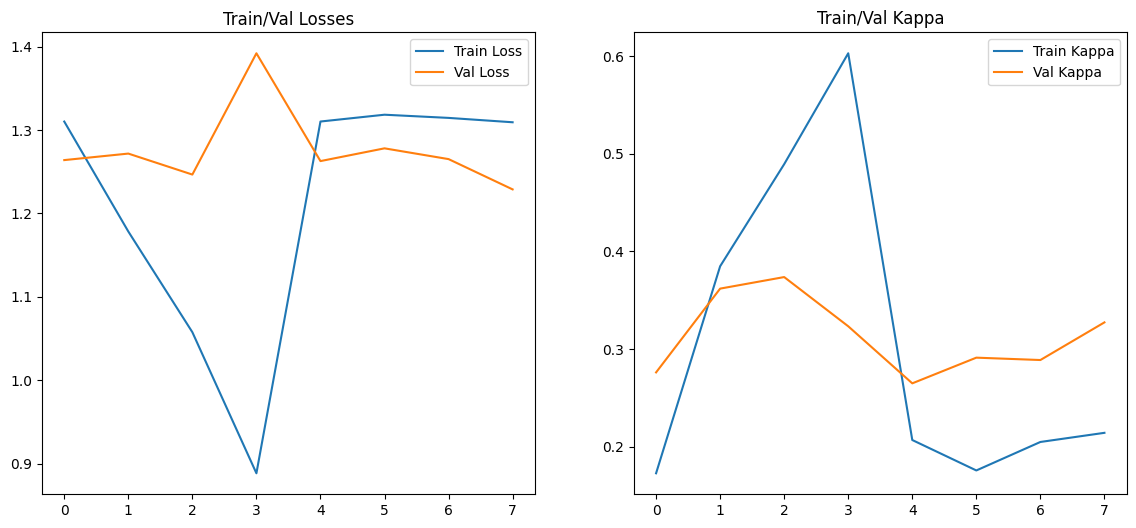

In [23]:
# 18. Візуалізація динаміки навчання
plot_training_curves(train_losses, val_losses, train_kappas, val_kappas)


In [24]:
# 19. Підготовка тестових даних
test_df = pd.read_csv(test_csv_path)
test_df = test_df.fillna({'Description': 'No description'})  # Заповнюємо відсутні значення

# Створюємо датасет для тестування
test_dataset = PetDataset(test_df, tokenizer, img_dir=test_img_dir, transform=image_transform, is_test=True)

# Створюємо test_loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [25]:
# 20. Створення файлу submission.csv
# Ініціалізація моделі з найкращими гіперпараметрами
model = MultimodalModel(
    num_layers=best_params['num_layers'],
    hidden_size=best_params['hidden_size'],
    dropout_rate=best_params['dropout_rate']
).to(device)

# Завантаження параметрів моделі
model.load_state_dict(torch.load('best_model_weights.pth', weights_only=True))



# Переключаємо модель в режим оцінки
model.eval()

submission = []
total_predicted = 0

with torch.no_grad():
    # Додаємо прогресбар для тестового набору даних
    for batch in tqdm(test_loader, desc="Predicting"):
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        images = batch['image'].to('cuda')

        outputs = model(input_ids, attention_mask, images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(predicted)):
            submission.append({
                'PetID': batch['PetID'][i],
                'AdoptionSpeed': predicted[i].item() + 1
            })
        total_predicted += len(predicted)

tqdm.write(f"Predicted samples: {total_predicted}")

Predicting: 100%|██████████| 30/30 [02:31<00:00,  5.04s/it]

Predicted samples: 1891


In [27]:
# 21. Збереження результатів у CSV
with open('submission_18_10_v1.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=['PetID', 'AdoptionSpeed'])
    writer.writeheader()
    for row in submission:
        writer.writerow(row)

print(f"Файл submission_18_10.csv створено! Загальна кількість передбачених зразків: {total_predicted}/n")




Файл submission_18_10.csv створено! Загальна кількість передбачених зразків: 1891/n
